# Wine Enthusiast Review Exploration
The workbook below uses roughly 150,000 wine reviews scraped from Wine Enthusiast in June 2017 and posted to Kaggle https://www.kaggle.com/zynicide/wine-reviews.

A detailed blog article can be found here http://www.jbencina.com/blog/2017/07/12/exploring-wine-enthusiast-reviews/

Using this data I explored a few topics:
1. What was the distribution of points assigned by Wine Enthusaiast overall (80-100 point scale)?
2. Which regions recieve the highest overall point distributions?
3. How do the top regions perform across a variety of wines?
4. Is there a relationship between price and points?
5. Can we use the descriptive text to find logical groupings of wines?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

grid_style = {
    'axes.edgecolor': '#CCCCCC',
    'font.family': ['Calibri'],
}

## Import Data
Load the data, but create a new column which is the Region_1, Province (eg. "Napa Valley, California"). Sometimes Region_1 doesn't have a value. For these records we just will load them as "Province, Other". 

*Warning: Lots of duplication in the data. Dropping duplicates shrinks the data from 150,930 to 97,851*

In [3]:
def get_data():
    df = pd.read_csv('dataset/winemag-data-130k-v2.csv')
    df['regprov'] = df.apply(lambda x: '{}, {}'.format(x.region_1 if x.region_1 is not np.nan else 'Other', x.province), axis=1)
    dff = df.drop_duplicates()
    print(df.shape[0], dff.shape[0])
    return dff

reviews = get_data()
reviews.head(3)



129971 129971


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,regprov
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,"Etna, Sicily & Sardinia"
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,"Other, Douro"
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,"Willamette Valley, Oregon"


In [4]:
len(reviews['variety'].unique())

708

## Ratings Distribution
The first two charts show the distributions of points. Only wines scoring over 80 are in the data set. No wine recieved a full 100. I was pleasently surprised to find the wines were mostly normally distributed and not stacked towards the upper end.

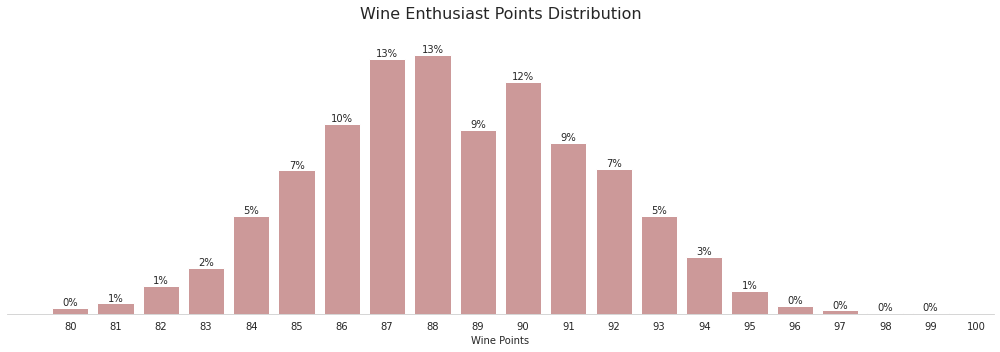

In [15]:
def ratings_distribution(data, cumulative):
    %matplotlib inline
    bin_start = 80
    bin_end = 100
    x_val = range(bin_start, bin_end + 1)
    
    sns.set_style('white', grid_style)
    
    plt.figure(figsize=(14,5))
    heights, _, _ = plt.hist(reviews.points, density=True,rwidth=0.8, bins=x_val, 
                             color='#CC9999', align='left', cumulative=cumulative)
    
    plt.xticks(x_val)
    plt.yticks([])
    plt.xlabel('Wine Points')
    
    if cumulative:
        plt.title("Wine Enthusiast Points Distribution - Cumulative\n", fontsize=16)
    else:
        plt.title("Wine Enthusiast Points Distribution\n", fontsize=16)

    
    sns.despine(left=True)
    
    yoffset = heights.max() * 0.01
    for x in range(bin_start, bin_end):
        plt.text(x, heights[x-bin_start] + yoffset, '{:.0%}'.format(heights[x-bin_start]), ha='center')
    
    plt.tight_layout()
    if cumulative:
        plt.savefig('points_cumulative.jpg', dpi=200)
    else:
        plt.savefig('points_bin.jpg', dpi=200)
           
ratings_distribution(reviews, False)

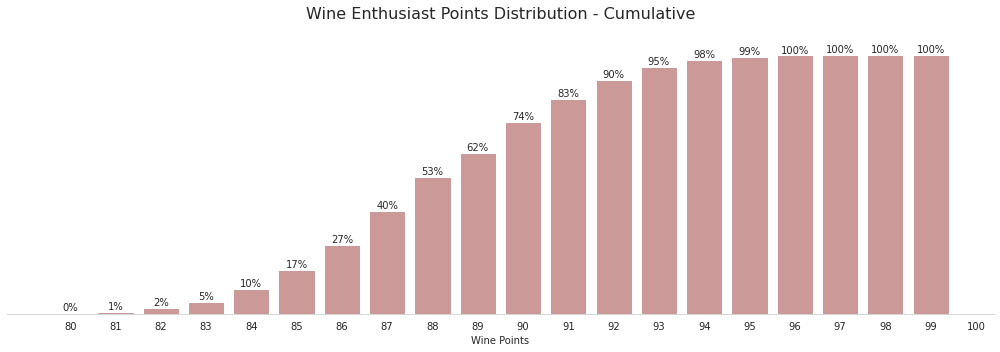

In [16]:
ratings_distribution(reviews, True)

## Showing Top Wine Regions
The following chart pulls together the top regions based on the # of total reviews. These are grouped, and an individual histogram is created for each region/province. Some additional code included is used to produce the desired visuals.

AttributeError: 'Rectangle' object has no property 'normed'

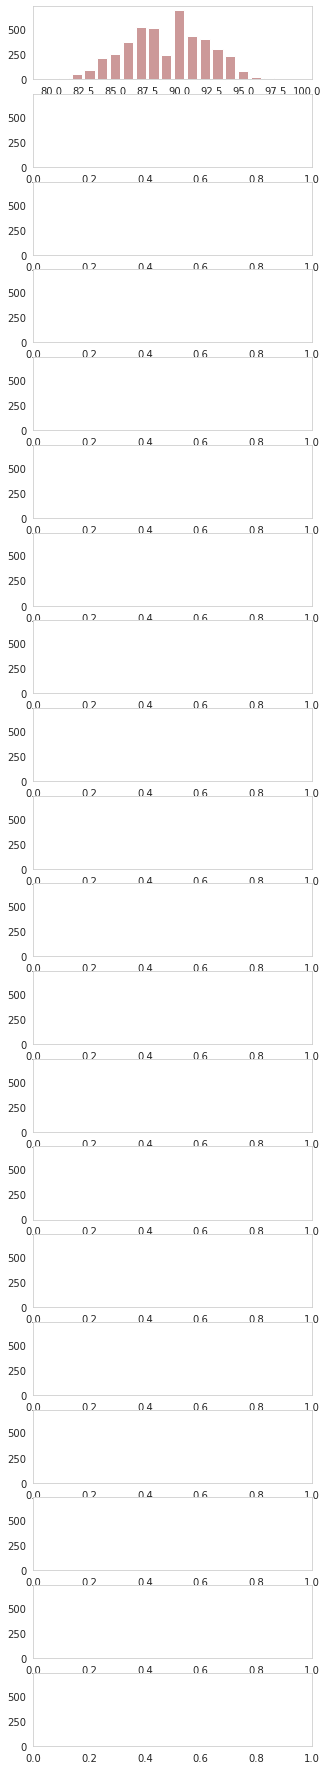

In [17]:
def get_top_entities(data, top_n, groupby):
    return data[groupby].value_counts().head(top_n).index
        
def plot_by_group_alt(data, groupby, top_n):
    bin_start = 80
    bin_end = 100
    
    # Slice data for only top N wins by # of reviews
    top = get_top_entities(data, top_n, groupby)
    df = data[data[groupby].isin(top)]
    
    x_vals = range(bin_start, bin_end + 1)
    fig, axarr = plt.subplots(top_n, 1, figsize=(5, top_n*1.6), sharey=True)
    
    # Left text are done in a second loop so track separately
    means = []
    counts = []
    all_boxes = []
    
    i = 0
    for idx in top:
        g = data[data[groupby]==idx]
        heights, _, boxes = axarr[i].hist(g['points'], normed=True, rwidth=0.8, 
                                 bins=x_vals, color='#CC9999', align='left')

        # Track # of reviews and mean score
        mean = g['points'].mean()
        count = len(g)
        
        means.append(mean)
        counts.append(count)
        all_boxes.append(boxes)
        
        #axarr[i].axvline(mean, color='#CCCCCC', linestyle='-')
        
        # Give each bar a nice color
        norm = mpl.colors.Normalize(vmin=0,vmax=heights.max()*1)
        cmap = sns.cubehelix_palette(bin_end - bin_start, start=2.8, rot=.1, as_cmap=True)
        cm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
        [b.set_facecolor(cm.to_rgba(b.get_height())) for b in boxes]
        
        sns.despine(ax=axarr[i], left=True, bottom=True)
        axarr[i].set_xlabel('')
        axarr[i].set_yticklabels([])
        axarr[i].set_xticks(x_vals)
        
        if i < top_n + 99:
            axarr[i].set_xticklabels([])

        i+=1
    
    ymax = axarr[len(top)-1].get_ybound()[1]
    i=0
    
    
    left_start = 62 # Adjust to shift text to the left
    spacer = 30 # Adjust to add space between the descriptive statistics
    
    for idx in top:
        title = axarr[i].text(left_start, ymax/2, idx, fontsize=17, color='#333333')
        
        #Compute the bounding box of the chart so we can offset the text relative to other elements
        window_bb = axarr[i].get_window_extent()
        window_h = window_bb.y1 - window_bb.y0
        ypp = ymax / window_h
        
        axarr[i].text(left_start, ymax/2 - (spacer * ypp), 
                      '{M:.1f} average\n{C:.1f}K reviews'.format(M=means[i], C=counts[i]/1000), fontsize=12,
                     color='#666666', weight='light',)

        i+=1   
        
    plt.suptitle("Wine Enthusiast Points Distribution - Top {} Regions".format(top_n), fontsize=24, x=.22)
    plt.subplots_adjust(top=.96)
    plt.savefig('wine_distribution.jpg', bbox_inches='tight')

plot_by_group_alt(reviews, 'regprov', 20)

## Showing Top Regions & Variety
The following heat map takes each of the top regions and pivots them against the top wines. The "top" is defined by most review counts. Each region & variety pair was calculated using the 90th percentile of the ratings received. For each variety, the highest region was shaded dark purple. The 2nd and 3rd place regions were shaded light purple. All regions not in the top 3 for that variety were left gray. White boxes signify no reivews for that combination.

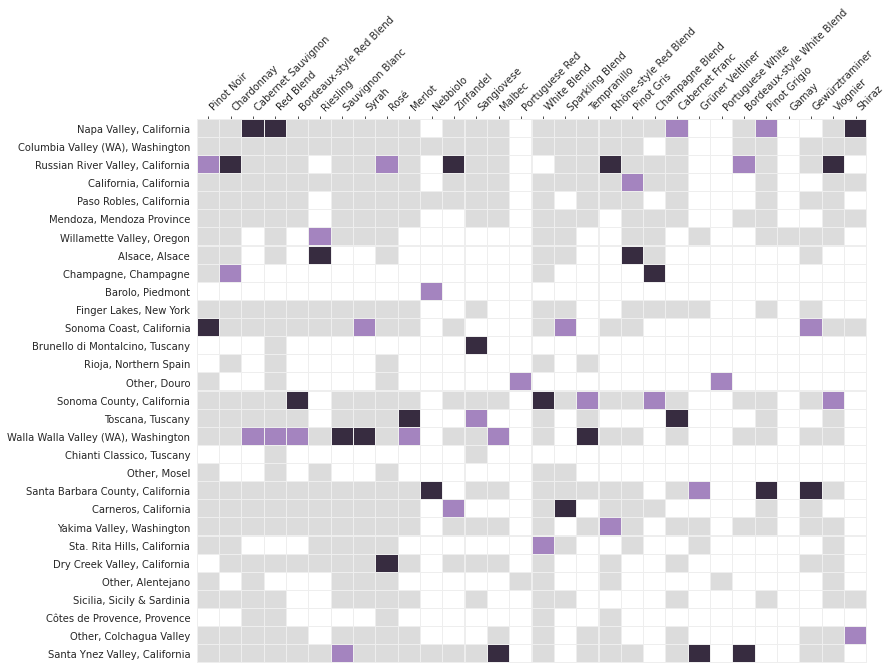

In [18]:
def top_n_row(r):
    # Ranks the first 3 values in a series (column) replacing all others with -1
    idx = r.dropna().index
    a =  r.argsort()
    a = [i for i in a if i>=0]
    max_top = (3 if len(idx)>=3 else len(idx)) * -1
    
    r.loc[idx[a[max_top:]]] = np.arange(max_top*-1)
    r.loc[idx[a[:max_top]]] = -1
    return r

def get_top_two(data, groupby, top_n):
    # Pivots the top 30 wines by review count against the top N regions
    top_group = data[groupby].value_counts().head(top_n).index
    top_wine = data['variety'].value_counts().head(30).index
    
    d = data[(data[groupby].isin(top_group)) & (data['variety'].isin(top_wine))]
    
    pvt = pd.pivot_table(d, index=groupby, columns='variety', values='points', aggfunc=(lambda x: np.percentile(x, 90)))
    pvt = pvt.loc[top_group, top_wine]
    
    pvt.apply(top_n_row, axis=0)
    return pvt

def plot_top_two(reviews, groupby, top_n):
    p = get_top_two(reviews, 'regprov', 30)
    # https://stackoverflow.com/questions/38836154/discrete-legend-in-seaborn-heatmap-plot for some inspiration
    # Frankly, I'm not sure why I need to repeat the last color. I'm probably missing something....
    rgb = [
        (220, 220, 220, 255),
        (220, 220, 220, 255),
        (164, 132, 191, 255),
        (164, 132, 191, 255),
        (55, 44, 64, 255)
    ]
    
    for t in range(0,len(rgb)):
        rgb[t] = [c/255 for c in rgb[t]]

    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom', rgb, len(rgb))

    plt.figure(figsize=(12,10))
    ax = sns.heatmap(p, cmap=cmap,
                    linecolor='#EEEEEE',
                    linewidths=0.1,
                     cbar_kws={"boundaries": np.linspace(-1, 4, 4)} ,
                     cbar=False
                    )
    ax.xaxis.tick_top()
    plt.xticks(rotation=45, ha='left')
    plt.savefig('wine_heatmap.jpg', bbox_inches='tight')

plot_top_two(reviews, 'regprov', 30)

## Wine Price vs. Ratings
There seems to be some relationship between price and ratings, however any linear model has a really low R^2 value for this. Instead, the following charts show the relationship across all wines (log scale) and sub-$100 wines (linear scale). There is a slight bend as prices increase, but it's nothing massive. If anything, it seems that you can find a 90+ wine at almost any price point, however a higher price just makes that more likely.

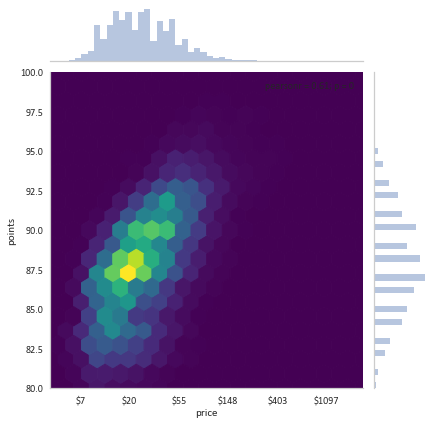

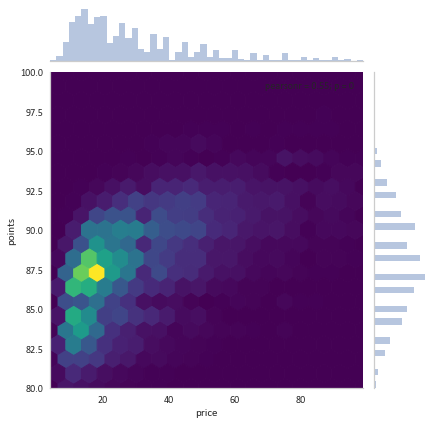

In [33]:
def show_price_points(reviews):
    import math
    d = reviews
    g = sns.jointplot(d.price.apply(lambda x: math.log(x)), d.points, kind='hex', 
                  gridsize=20, cmap='viridis')

    g.ax_joint.set_xticklabels(['${:.0f}'.format(math.exp(x)) for x in range(1,9)])
    plt.savefig('wine_price_point_log.jpg', bbox_inches='tight')
    
    d = reviews[reviews.price<100]
    sns.jointplot(d.price, d.points, kind='hex', gridsize=20, cmap='viridis')
    plt.savefig('wine_price_point.jpg', bbox_inches='tight')
show_price_points(reviews)

## Classifying Wines by Description
We perform TFIDF vectorization against the wine descriptions in order to create clusters of wines. When I first ran this, I didn't realize that often the wine variety is repeated within the description. So I modified the stop words to remove the varities as well as some other uninteresting words that popped up. I also didn't care if a word was used once or many times. So the vectorizer uses binary calculations.

After running the TFIDF vectorizer across all 150K reviews, I grouped each wine variety and averaged the scores.

In [29]:
reviews = reviews.dropna(subset=['variety'])

In [8]:
len(reviews['winery'].unique())

16757

In [9]:
len(reviews['variety'].unique())

708

In [43]:
from nltk.stem import PorterStemmer 

stemmer = PorterStemmer()

dic = {}
dic[stemmer.stem("darkfruit")] = "dark fruit, blackcurrant, blueberry, blue fruits, black cherry, black fruit, blackberry, cassis, juniper, mulberry, plum".split(', ')
dic[stemmer.stem("redfruit")] = "red fruit, red cherry, red berry, red currant, boysenberry, cranberry,raspberry, strawberry".split(', ')
dic[stemmer.stem("ripefruit")] = "ripe berry, apricot, fruit cake, fig, jam, overripe, porty,prune, raisin, shrivelled, ripe fruit".split(', ')
dic[stemmer.stem("savoury")] = "savoury, sea salt, barbeque sauce, beef stock, gamey, iodine,meat, oyster, pancetta, salty, salami, sea spray, seaweed, soysauce, steak, vegemite".split(', ')
dic[stemmer.stem("nuts")] = "nuts, almond, chestnut, nutty".split(', ')
dic[stemmer.stem("sage")] = "herbal, bay leaf, herbaceous, rosemary, tea, thyme, sage".split(', ')
dic[stemmer.stem("weedy")] = "green, dill, grass, capsicum, sappy, shaded, stalky, vegetal, weedy".split(', ')
dic[stemmer.stem("oaky")] = "oaky, cigar box, coffee beans, burnt, butterscotch, caramel, cedar,chocolate, cocoa, coconut, mocha, tarry, vanilla, woody".split(', ')
dic[stemmer.stem("cookedveg")] = "cooked vegetable, canned green bean, sulphide, vegetable, eggplant".split(', ')
dic[stemmer.stem("zesty")] = "jaffa, orange, chinotto, rhubarb, zesty".split(', ')
dic[stemmer.stem("earthy")] = "earthy, forest floor, dirt, dust, fungal, mossy, muddy,mushroom, musk".split(', ')
dic[stemmer.stem("inorganic")] = ["minerality", "graphite", "petichor", "unctuous", "oily", "petroleum", "plastic" , "tar", "rubber", "diesel", "smoky" ]
dic[stemmer.stem("weedy")] += ["stemmy", "stalky", "vegetal", "cat's pee", "asparagus", "green", "grassy", "sage", "eucalyptus", "jalapeno", "dill", "bell pepper", "gosseberry", "quince"]
dic[stemmer.stem("oaky")] += ["smoky", "charcoal", "sweet tobacco", "toasty"]
dic[stemmer.stem("flower")] = ["white flowers", "violet"]
dic[stemmer.stem("ripefruit")] += ["jammy", "ripe", "juicy"]
dic[stemmer.stem("spice")] = ["spicy", "musky", "bright", "pepper"]
dic[stemmer.stem("acid")] = ["bright", "astringent", "austere"]
dic[stemmer.stem("tannin")] = ["bitter", "harsh", "agressive"]

for name, l in dic.items():
    dic[name] = [stemmer.stem(e) for e in l]

    

In [44]:
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer('[a-z]+')

def tokenize(s):
    tokenizer.tokenize(s.lower)

def tokenize_replace_by_common_descriptors(s):
    s_words = tokenizer.tokenize(s.lower())
    ws = []
    
    for w in s_words:
        w = stemmer.stem(w)
        for name,l in dic.items():
            if w in l:
                w=name
        ws.append(w)
        
    return ws
        
#s = "dark fruit, blackcurrant, blueberry, blue fruits, black cherry, black fruit, blackberry, cassis, juniper, mulberry, plum" 
s = reviews.iloc[5]['description']
print(s)
print(tokenize_replace_by_common_descriptors(s))

Blackberry and raspberry aromas show a typical Navarran whiff of green herbs and, in this case, horseradish. In the mouth, this is fairly full bodied, with tomatoey acidity. Spicy, herbal flavors complement dark plum fruit, while the finish is fresh but grabby.
['darkfruit', 'and', 'raspberri', 'aroma', 'show', 'a', 'typic', 'navarran', 'whiff', 'of', 'weedi', 'herb', 'and', 'in', 'thi', 'case', 'horseradish', 'in', 'the', 'mouth', 'thi', 'is', 'fairli', 'full', 'bodi', 'with', 'tomatoey', 'acid', 'spice', 'weedi', 'flavor', 'complement', 'dark', 'darkfruit', 'fruit', 'while', 'the', 'finish', 'is', 'fresh', 'but', 'grabbi']


In [55]:
descriptors = [ ]
for n,l in dic.items():
    descriptors+=l

def hasInterestingWords(r):
    s = r['description']
    ws = tokenize_replace_by_common_descriptors(s)
    c = 0
    for w in ws:
        if w in descriptors:
            c+=1
    return c

reviews['test'] = reviews.apply(hasInterestingWords, axis = 1)
reviews.head()


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,regprov,test
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,"Etna, Sicily & Sardinia",1
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,"Other, Douro",0
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,"Willamette Valley, Oregon",1
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,"Lake Michigan Shore, Michigan",1
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,"Willamette Valley, Oregon",2


In [67]:
sum(reviews['test'])/reviews.shape[0]
print(reviews['description'].iloc[1])
tokenize_replace_by_common_descriptors(reviews['description'].iloc[1])
stemmer.stem("ripefruit") in descriptors
mean(reviews['test'])

This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016.


NameError: name 'mean' is not defined

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import stop_words

def tokenize(s):
    tokenizer.tokenize(s.lower)

def get_stops(varieties):
    stops = set(stop_words.ENGLISH_STOP_WORDS)
    wines = set([w for v in varieties.unique() for w in tokenize_replace_by_common_descriptors(v)]) | set(['red','white','zin',
                                                                              'flavor','flavors','wine','wines'])
    
    return stops | wines



def get_tfidf_average(reviews, top_n):
    stops = get_stops(reviews['variety'])
    tfidf_m = TfidfVectorizer(tokenizer=tokenize_replace_by_common_descriptors, binary=False, min_df=0.01, 
                              max_df=0.95, stop_words=stops, ngram_range=(1, 2)).fit(reviews['description'])
    tfidf_d = tfidf_m.transform(reviews['description'])
    
    df = pd.DataFrame(tfidf_d.toarray()).set_index(reviews['variety'])
    df.columns = tfidf_m.get_feature_names()
    
    print(df.head())
    
    top_wines = reviews['variety'].value_counts().head(top_n).index
    
    df_agg = df.loc[top_wines].groupby(level=0).mean()
    
    return df_agg

reviews['variety'].head()

#tf_wines
    
tf_wines = get_tfidf_average(reviews, 60)
tf_wines.head()

/home/delairra/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/home/delairra/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alic', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'carric', 'cesan', 'cort', 'counoi', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'mascal', 'meanwhil', 'mondeu', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', '

                accent      acid  add  aftertast  age  age drink  alcohol  \
variety                                                                     
White Blend        0.0  0.134733  0.0        0.0  0.0        0.0      0.0   
Portuguese Red     0.0  0.136853  0.0        0.0  0.0        0.0      0.0   
Pinot Gris         0.0  0.162861  0.0        0.0  0.0        0.0      0.0   
Riesling           0.0  0.136675  0.0        0.0  0.0        0.0      0.0   
Pinot Noir         0.0  0.000000  0.0        0.0  0.0        0.0      0.0   

                alongsid   alreadi  ampl  ...  winemak  wineri  wood  \
variety                                   ...                          
White Blend       0.2614  0.000000   0.0  ...      0.0     0.0   0.0   
Portuguese Red    0.0000  0.328689   0.0  ...      0.0     0.0   0.0   
Pinot Gris        0.0000  0.000000   0.0  ...      0.0     0.0   0.0   
Riesling          0.0000  0.000000   0.0  ...      0.0     0.0   0.0   
Pinot Noir        0.0000  0.

,accent,acid,add,aftertast,age,age drink,alcohol,alongsid,alreadi,ampl,...,winemak,wineri,wood,wood age,wrap,year,yellow,young,youth,zest
variety,,,,,,,,,,,,,,,,,,,,,
Aglianico,0.011099,0.024334,0.005330,0.000645,0.017155,0.000000,0.007570,0.030304,0.010979,0.001667,...,0.001676,0.001431,0.007285,0.000000,0.000763,0.018410,0.000000,0.005976,0.008049,0.002533
Albariño,0.003426,0.056795,0.001196,0.000537,0.008955,0.000538,0.006052,0.000628,0.002434,0.006122,...,0.001302,0.003642,0.003791,0.000000,0.000629,0.008080,0.008588,0.001909,0.001371,0.001832
Barbera,0.010569,0.054417,0.007671,0.000867,0.012822,0.000880,0.009597,0.040191,0.002398,0.001180,...,0.003306,0.005905,0.006740,0.000000,0.003878,0.007120,0.000000,0.005716,0.001869,0.004454
Blaufränkisch,0.008320,0.046629,0.007221,0.009699,0.036828,0.002729,0.000000,0.000000,0.007482,0.011915,...,0.002744,0.001518,0.033832,0.010602,0.000000,0.032620,0.000000,0.010584,0.000000,0.001388
Bordeaux-style Red Blend,0.004328,0.054511,0.005389,0.012519,0.055534,0.013542,0.004408,0.001521,0.015417,0.002399,...,0.004115,0.005066,0.057847,0.021433,0.001681,0.031446,0.000201,0.014648,0.004440,0.000079


In [48]:
list(tf_wines.columns.values)

['accent',
 'acid',
 'add',
 'aftertast',
 'age',
 'age drink',
 'alcohol',
 'alongsid',
 'alreadi',
 'ampl',
 'anis',
 'anoth',
 'appeal',
 'appel',
 'approach',
 'aroma',
 'aroma lead',
 'aromat',
 'attract',
 'bake',
 'bake spice',
 'balanc',
 'barrel',
 'base',
 'beauti',
 'befor',
 'berri',
 'berri aroma',
 'berri fruit',
 'best',
 'better',
 'big',
 'bit',
 'blossom',
 'blue',
 'boast',
 'bodi',
 'bold',
 'bottl',
 'bouquet',
 'brambl',
 'bring',
 'brisk',
 'butter',
 'cab',
 'candi',
 'carri',
 'cedar',
 'cellar',
 'char',
 'charact',
 'cherri',
 'cherri darkfruit',
 'cherri fruit',
 'cherri raspberri',
 'chewi',
 'chocol',
 'chunki',
 'cinnamon',
 'citru',
 'classic',
 'clean',
 'close',
 'clove',
 'coffe',
 'cola',
 'color',
 'combin',
 'come',
 'complex',
 'concentr',
 'cool',
 'core',
 'cranberri',
 'cream',
 'creami',
 'crisp',
 'crisp acid',
 'crush',
 'currant',
 'cut',
 'dark',
 'dark chocol',
 'dark fruit',
 'darkfruit',
 'darkfruit cherri',
 'darkfruit currant',
 'dark

## Hierarchical Clustering by Description
Using the dendogram I set a threshold which cut the data into logical groupings. The only outlier was Rose which does not have a threhshold value which would include it without combining another. 

Overall I was very satisified with the results. At a very top level we were able to separate red wines from white wines (with Rose counting as a white). Further down, wines seemed to be grouped into clusters which I would consider pretty accurate. I expected/hoped as much based on the source of the review descriptions. 

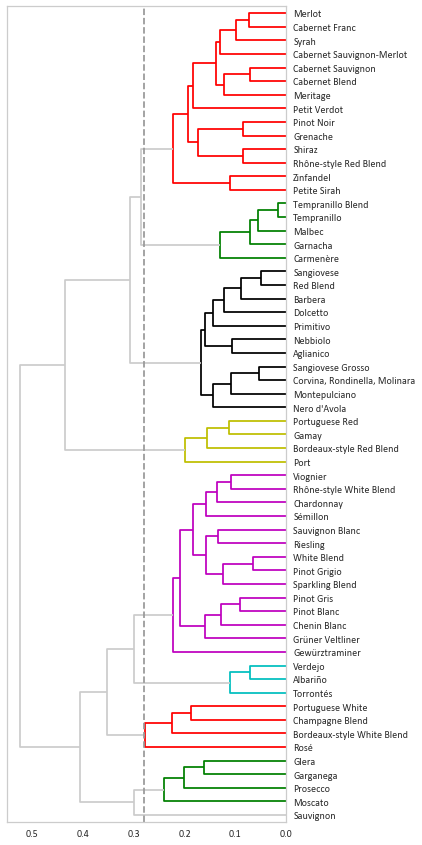

In [35]:
&def cluster_wines(tf_matrix, threshold):
    from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
    l = linkage(tf_matrix, method='average', metric='cosine')    
    plt.figure(figsize=(5,15))
    r = dendrogram(l, color_threshold=threshold, labels=tf_matrix.index.values, orientation='left', leaf_font_size=10,
                  above_threshold_color='#CCCCCC')
    
    plt.axvline(threshold, color='#999999', linestyle='--')
    
    clusts = fcluster(l, t=threshold, criterion='distance')
    plt.savefig('wine_dendro.jpg', bbox_inches='tight')
    return clusts
    
wine_clusters = cluster_wines(tf_wines, threshold=.280)

## Descrbing the Clusters
From the data we were able to identify 9 clusters (Rose is by itself) in the dendrogram. Using the cluster lables, and the TFIDF matrix, I selected the top words for each cluster along with 5 random grape varities found in that cluster.

In [36]:
def top_words(tf_matrix, n_words, clusters=None):
    df = tf_matrix.copy()
    
    if clusters is not None:           
        df['cluster'] = clusters
        df = df.set_index('cluster', append=True).groupby(level=1).mean()
        
    for name, grp in df.groupby(level=0):
        order = np.argsort(-grp.values)[0][:n_words]
        
        if clusters is not None:
            print('\n***Cluster - {}***'.format(name))
            df_wines = tf_matrix.index.values[clusters==name]
            max_sel = len(df_wines) if len(df_wines)<5 else 5
            df_wines = np.random.choice(df_wines, max_sel, replace=False)

            print('Varities: ' + ', '.join([c for c in df_wines]))
        else:
            print('\n***Variety - {}***'.format(name))

        print('Top Words: ' + ', '.join([c for c in grp.columns[order]]))
        

        
top_words(tf_wines, 20, clusters=wine_clusters)


***Cluster - 1***
Varities: Garganega, Glera, Prosecco, Moscato
Top Words: peach, aromas, honey, sweet, stone, fruit, mineral, flower, creamy, fresh, citrus, offers, tones, almond, pair, floral, mouth, apricot, crisp, opens

***Cluster - 2***
Varities: Sauvignon
Top Words: tomato, aromas, peach, exotic, fruit, palate, offers, crisp, fresh, acidity, mineral, stone, delivers, citrus, yellow, grapefruit, aromatic, green, mouth, note

***Cluster - 3***
Varities: Bordeaux-style White Blend, Rosé, Portuguese White, Champagne Blend
Top Words: acidity, crisp, fresh, ripe, character, fruity, drink, light, fruits, rich, texture, fruit, citrus, soft, attractive, ready, dry, bright, great, sample

***Cluster - 4***
Varities: Albariño, Verdejo, Torrontés
Top Words: aromas, palate, finish, citrus, nose, green, peach, lime, tropical, feels, fresh, lemon, drink, clean, good, fruit, acidity, feel, grapefruit, pineapple

***Cluster - 5***
Varities: Riesling, White Blend, Sémillon, Grüner Veltliner, Sau